In [40]:
import sys
print(sys.version) # python 3.6
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
print(torch.__version__) # 1.0.1
torch.manual_seed(23801)

%matplotlib inline
import matplotlib.pyplot as plt

def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())
    plt.savefig('./fig.pdf')

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
1.11.0.dev20211104+cu111


In [41]:
# let's download the Fashion MNIST data, if you do this locally and you downloaded before,
# you can change data paths to point to your existing files
# dataset = torchvision.datasets.MNIST(root='./MNISTdata', ...)
dataset = torchvision.datasets.FashionMNIST(root='./FashionMNIST/',
                       transform=transforms.Compose([transforms.Resize(32),
                                                    transforms.ToTensor(),
                                                     transforms.Normalize((0.5,), (0.5,))]),
                       download=True)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# Define the Generator and Discriminator

In [42]:
class Discriminator(torch.nn.Module):
    def __init__(self, inp_dim=784):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(inp_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = x.view(x.size(0), 784) # flatten (bs x 1 x 28 x 28) -> (bs x 784)
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.sigmoid(out)
        return out

class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 784)
    def forward(self, x):
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.tanh(out) # range [-1, 1]
        # convert to image 
        out = out.view(out.size(0), 1, 28, 28)
        return out

In [43]:
class CNNDiscriminator(nn.Module):
    def __init__(self, features=64):
        super(CNNDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, features, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features, features*2, 4, 2, 1),
            nn.BatchNorm2d(features*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features*2, features*4, 4, 2, 1),
            nn.BatchNorm2d(features*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features*4, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )
    def forward(self, img):
        validity = self.model(img)
        return validity.view(-1, 1)

class CNNGenerator(nn.Module):
    def __init__(self, latent_dim=100, features=64):
        super(CNNGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, features*8, 4, 1, 0),
            nn.ReLU(True),

            # Transpose block 3
            nn.ConvTranspose2d(features*8, features*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*4),
            nn.ReLU(),

            # Transpose block 4
            nn.ConvTranspose2d(features*4, features*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*2),
            nn.ReLU(),

            # Last transpose block (different)
            nn.ConvTranspose2d(features*2, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        img = self.model(z)
        return img
        

### 4. Back to GANs: The min-max game.
We introduced and defined the generator G, the discriminator D, and the dataloader which will give us minibatches of real data. With the intermezzo on optimization we also understand how we optimize neural networks in pytorch.

To recap the basic idea of the min-max / adversarial game:
* The Generator and Discriminator have competing objectives, they are "adversaries".
* The Discriminator wants to assign high probability to real images and low probability to generated (fake) images
* The Generator wants its generated images to look real, so wants to modify its outputs to get high scores from the Discriminator
* We will optimize both alternatingly, with SGD steps (as before): optimize $\theta_D$ the weights of $D(x, \theta_D)$, and  $\theta_G$ the weights of $G(z, \theta_G)$.
* Final goal of the whole min-max game is for the Generator to match the data distribution: $p_G(x) \approx p_{data}(x)$.


Now what are the objective functions for each of them? As mentioned in the introduction, the objective for the discriminator is to classify the real images as real, so $D(x) = 1$, and the fake images as fake, so $D(G(z))=0$.
This is a typical binary classification problem which calls for the binary cross-entropy (BCE) loss, which encourages exactly this solution.

For G we just try to minimize the same loss that D maximizes. See how G appears inside D? This shows how the output of the generator G is passed into the Discriminator to compute the loss.


This is the optimization problem:

$$
\min _{G} \max _{D} V(D, G)=\mathbb{E}_{\boldsymbol{x} \sim p_{\text { data }}(\boldsymbol{x})}[\log D(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}[\log (1-D(G(\boldsymbol{z})))]
$$

We will do a single SGD step alternatingly to maximize D, then minimize G.
In fact for G we use a modified (non-saturing) loss $-\log D(G(z))$. Different modifications of the loss and the relation to the distance between distributions $p_{data}$ and $p_{G}$ became a topic of research over the last years.


In [44]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device: ', device)

D = CNNDiscriminator().to(device)
G = CNNGenerator().to(device)

print(D)
print(G)

Device:  cuda
CNNDiscriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2))
    (9): Sigmoid()
  )
)
CNNGenerator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

epoch0.iter0/938 last mb D(x)=0.5363 D(G(z))=0.1430
epoch0.iter100/938 last mb D(x)=0.9967 D(G(z))=0.0006
epoch0.iter200/938 last mb D(x)=0.9970 D(G(z))=0.0004
epoch0.iter300/938 last mb D(x)=0.9320 D(G(z))=0.0569
epoch0.iter400/938 last mb D(x)=0.9983 D(G(z))=0.0033
epoch0.iter500/938 last mb D(x)=0.9444 D(G(z))=0.0297
epoch0.iter600/938 last mb D(x)=0.9773 D(G(z))=0.0055
epoch0.iter700/938 last mb D(x)=0.9321 D(G(z))=0.0169
epoch0.iter800/938 last mb D(x)=0.9282 D(G(z))=0.0412
epoch0.iter900/938 last mb D(x)=0.8902 D(G(z))=0.2074
epoch1.iter0/938 last mb D(x)=0.9641 D(G(z))=0.0059
epoch1.iter100/938 last mb D(x)=0.7961 D(G(z))=0.0232
epoch1.iter200/938 last mb D(x)=0.9823 D(G(z))=0.0427
epoch1.iter300/938 last mb D(x)=0.9657 D(G(z))=0.0495
epoch1.iter400/938 last mb D(x)=0.9000 D(G(z))=0.0121
epoch1.iter500/938 last mb D(x)=0.8146 D(G(z))=0.1394
epoch1.iter600/938 last mb D(x)=0.8090 D(G(z))=0.0367
epoch1.iter700/938 last mb D(x)=0.9010 D(G(z))=0.0119
epoch1.iter800/938 last mb D(x)=

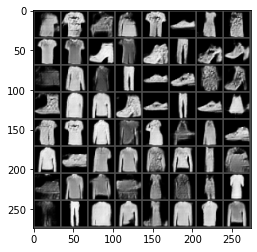

In [45]:
# Now let's set up the optimizers (Adam, better than SGD for this)
# optimizerD = torch.optim.SGD(D.parameters(), lr=0.01)
# optimizerG = torch.optim.SGD(G.parameters(), lr=0.01)
optimizerD = torch.optim.Adam(D.parameters(), lr=0.0005)
optimizerG = torch.optim.Adam(G.parameters(), lr=0.0005)
criterion = nn.BCELoss()
lab_real = torch.ones(64, 1, device=device)
lab_fake = torch.zeros(64, 1, device=device)

# for logging:
collect_x_gen = []
fixed_noise = torch.randn(64, 100, device=device)
fig = plt.figure() # keep updating this one
plt.ion()

loss_d = []
loss_g = []
pro_d = []
pro_g = []

# Train:

epochs = 15

for epoch in range(epochs):
    l_d = 0
    l_g = 0
    p_d = 0
    p_g = 0
    for i, data in enumerate(dataloader, 0):
        # STEP 1: Discriminator optimization step
        x_real, _ = iter(dataloader).next()
        x_real = x_real.to(device)
        # reset accumulated gradients from previous iteration
        optimizerD.zero_grad()

        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        z = torch.randn(64, 100, device=device) # random noise, 64 samples, z_dim=100
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()
        
        l_d += lossD
        p_d += D_x.mean()

        # STEP 2: Generator optimization step
        # reset accumulated gradients from previous iteration
        optimizerG.zero_grad()

        z = torch.randn(64, 100, device=device) # random noise, 64 samples, z_dim=100
        x_gen = G(z)
        D_G_z = D(x_gen)
        lossG = criterion(D_G_z, lab_real) # -log D(G(z))

        l_g += lossG
        p_g += D_G_z.mean()

        lossG.backward()
        optimizerG.step()

        if i % 100 == 0:
            x_gen = G(fixed_noise)
            show_imgs(x_gen, new_fig=False)
            fig.canvas.draw()
            print('epoch{}.iter{}/{} last mb D(x)={:.4f} D(G(z))={:.4f}'.format(
                epoch, i, len(dataloader), D_x.mean().item(), D_G_z.mean().item()))
    # End of epoch
    pro_d.append(p_d / len(dataloader))
    loss_d.append(l_d / len(dataloader))

    pro_g.append(p_g / len(dataloader))
    loss_g.append(l_g / len(dataloader))
    
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())

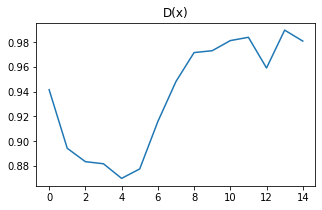

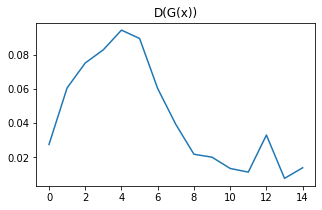

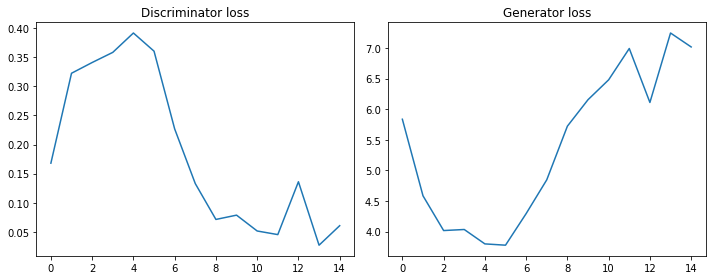

In [46]:
import numpy as np

plt.figure(figsize=(5,3))
plt.plot(pro_d)
plt.title('D(x)')

plt.figure(figsize=(5,3))
plt.plot(pro_g)
plt.title('D(G(x))')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)  # 创建第一个subplot
plt.plot(loss_d)
plt.title('Discriminator loss')

# 绘制生成器损失图
plt.subplot(1, 2, 2)  # 创建第二个subplot
plt.plot(loss_g)
plt.title('Generator loss')

# 调整子图间距
plt.tight_layout()

# 显示图像
plt.show()

# Generate by control random num

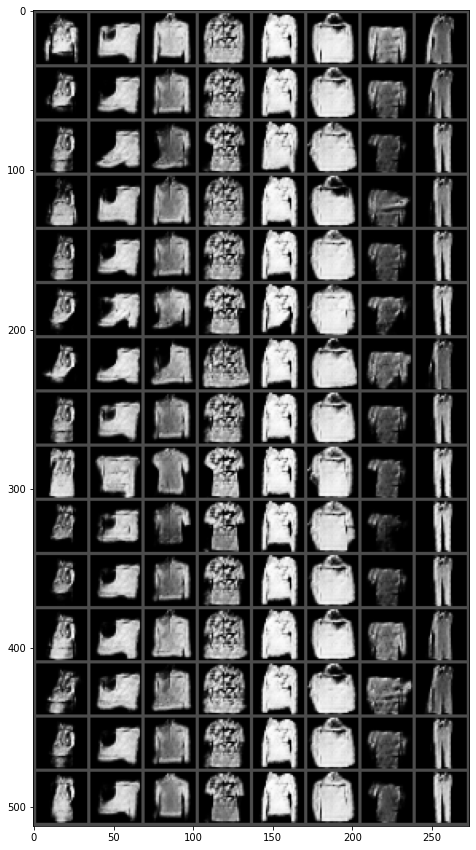

In [47]:
# 8 random pic

z = torch.randn(8, 100, device=device) # random noise, 8 samples, z_dim=100
z = z.repeat(15, 1)

n = 3

for i in range(0, 8):
    z[i][5] = -n
for i in range(8, 16):
    z[i][5] = 0
for i in range(16, 24):
    z[i][5] = n

for i in range(24, 32):
    z[i][25] = -n
for i in range(32, 40):
    z[i][25] = 0
for i in range(40, 48):
    z[i][25] = n

for i in range(48, 56):
    z[i][45] = -n
for i in range(56, 64):
    z[i][45] = 0
for i in range(64, 72):
    z[i][45] = n

for i in range(72, 80):
    z[i][65] = -n
for i in range(80, 88):
    z[i][65] = 0
for i in range(88, 96):
    z[i][65] = n

for i in range(96, 104):
    z[i][85] = -n
for i in range(104, 112):
    z[i][85] = 0
for i in range(112, 120):
    z[i][85] = n

x_gen = G(z)


grid = vutils.make_grid(x_gen.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
plt.figure(figsize=(8, 15))
plt.imshow(grid.numpy())
plt.savefig('./fig.pdf')

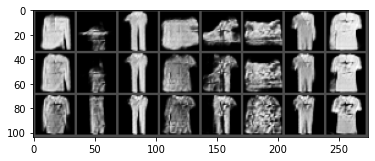

In [48]:
z = torch.randn(8, 100, device=device) # random noise, 8 samples, z_dim=100
z = z.repeat(3, 1)

for i in range(0, 8):
    z[i][50] = 0.
for i in range(8, 16):
    z[i][50] = 3
for i in range(16, 24):
    z[i][50] = 9

x_gen = G(z)

show_imgs(x_gen)